In [1]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [13]:
def plot_roc(fpr, tpr, roc_auc, color='darkorange', label=''):
    plt.plot(fpr, tpr, color=color,
             lw=2, label=label + 'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')
    plt.legend(loc="lower right")
    plt.tight_layout()

### Read data file

In [3]:
df_all = pd.read_csv('./data/data_all.csv')
df_test = pd.read_csv('./data/data_test.csv')
df_dict = {}
for i in range(9):
    df_dict[i] = pd.read_csv('./data/data_readers_{}.csv'.format(i))

### TI-RADS

In [4]:
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)
df_features = df_all_categorical

df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Shape_0', 'Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)

df_features['ID'] = df_all['ID']
test_ids = np.intersect1d(df_all['ID'], df_test['ID'])
df_features = df_features[df_features.ID.isin(test_ids)]
df_features.drop(columns=['ID'], inplace=True)
df_test = df_all[df_all.ID.isin(test_ids)]

w = np.array([[2, 0, 2, 1, 0, 1, 1, 1, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]])

X_test = df_features.as_matrix()

x_cyst = X_test[:, 1]
x_cyst = np.abs(x_cyst - 1)
x_spon = X_test[:, 4]
x_spon = np.abs(x_spon - 1)

X_test = X_test * np.expand_dims(x_cyst, axis=-1)
X_test = X_test * np.expand_dims(x_spon, axis=-1)

y_points_tirads_test = np.dot(X_test, w.T).flatten()

y_true_tirads_test = df_test.Cancer

### Deep learning

In [5]:
df_dl = pd.read_csv('./data/predictions_test.csv')
y_pred_dl_test = df_dl['Prediction'].as_matrix()
y_true_dl_test = df_dl['Cancer'].as_matrix()

### Prediction based on TI-RADS

In [6]:
fpr_dl, tpr_dl, _ = roc_curve(y_true_dl_test, y_pred_dl_test)
roc_auc_dl = roc_auc_score(y_true_dl_test, y_pred_dl_test)

fpr_tirads, tpr_tirads, _ = roc_curve(y_true_tirads_test, y_points_tirads_test)
roc_auc_tirads = roc_auc_score(y_true_tirads_test, y_points_tirads_test)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(9):
    fpr_reader, tpr_reader, _ = roc_curve(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['TIRADS points'].as_matrix())
    roc_auc_reader = roc_auc_score(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['TIRADS points'].as_matrix())
    fpr[i] = fpr_reader
    tpr[i] = tpr_reader
    roc_auc[i] = roc_auc_reader

### Results analysis

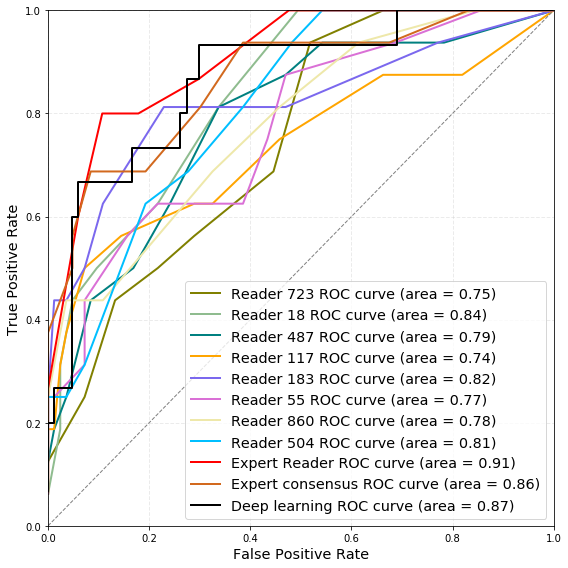

In [14]:
plt.figure(figsize=(8, 8))
colors = ['olive', 'darkseagreen', 'teal', 'orange', 'mediumslateblue', 'orchid', 'palegoldenrod', 'deepskyblue', 'chocolate']
for i in range(8):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    label = 'Reader {} '.format(user_id)
    plot_roc(fpr[i], tpr[i], roc_auc[i], color=colors[i], label=label)
plot_roc(fpr_tirads, tpr_tirads, roc_auc_tirads, color='red', label='Expert Reader ')
plot_roc(fpr[8], tpr[8], roc_auc[8], color=colors[8], label='Expert consensus ')
plot_roc(fpr_dl, tpr_dl, roc_auc_dl, color='black', label='Deep learning ')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.title('', fontsize='xx-large')
plt.legend(loc='lower right', fontsize='x-large')
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)